Streamlit App link - https://app-ml-3-task-1.streamlit.app/


In [23]:
# Set the environment variable for PyTorch CUDA memory management
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim  
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint
import re
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, TensorDataset
import random
import pickle

In [ ]:
# Set random seed
random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [24]:
torch.__version__

'2.4.0'

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [26]:
!wget https://www.gutenberg.org/files/1661/1661-0.txt -O sherlock.txt

--2024-10-28 06:23:19--  https://www.gutenberg.org/files/1661/1661-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607504 (593K) [text/plain]
Saving to: 'sherlock.txt'

sherlock.txt        100%[===================>] 593.27K  1.64MB/s    in 0.4s    

2024-10-28 06:23:20 (1.64 MB/s) - 'sherlock.txt' saved [607504/607504]



In [27]:
!head sherlock.txt

The Project Gutenberg eBook of The Adventures of Sherlock Holmes,
by Arthur Conan Doyle

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this eBook or online at
www.gutenberg.org. If you are not located in the United States, you
will have to check the laws of the country where you are located before
using this eBook.


In [28]:
!tail sherlock.txt


Most people start at our website which has the main PG search
facility: www.gutenberg.org.

This website includes information about Project Gutenberg™,
including how to make donations to the Project Gutenberg Literary
Archive Foundation, how to help produce our new eBooks, and how to
subscribe to our email newsletter to hear about new eBooks.




In [29]:
# Open the file
with open('sherlock.txt', 'r') as file:
    text = file.read()
    
text = re.sub(r'[^a-zA-Z0-9IVXLCDMivxlcdm. ]', ' ', text)

text = text.lower()

sentences = re.split(r'(?<=\.)\s*', text)

sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

# Print the list of sentences
print(len(sentences))
for i in range(10):
    print(sentences[i])

6431
the project gutenberg ebook of the adventures of sherlock holmes  by arthur conan doyle  this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever.
you may copy it  give it away or re use it under the terms of the project gutenberg license included with this ebook or online at www.
gutenberg.
org.
if you are not located in the united states  you will have to check the laws of the country where you are located before using this ebook.
title  the adventures of sherlock holmes  author  arthur conan doyle  release date  november 29  2002  ebook  1661   most recently updated  october 10  2023   language  english  character set encoding  utf 8  produced by  an anonymous project gutenberg volunteer and jose menendez      start of the project gutenberg ebook the adventures of sherlock holmes         the adventures of sherlock holmes  by arthur conan doyle   contents     i.
a scandal in bohemia 

In [30]:
# Set the context length
context_len = 5  

# Tokenize the sentences into words
words = []
for sentence in sentences:
    word = re.findall(r'\w+|[.]', sentence)  
    words.extend(word)   
    
# Get unique words and sort them
unique_words = sorted(list(set(words)))

# Create word-to-index (stoi) and index-to-word (itos) mappings
stoi = {word: i+1 for i, word in enumerate(unique_words)}  
stoi['<PAD>'] = 0
itos = {i: word for word, i in stoi.items()}
stoi['<UNK>'] = len(stoi)
itos[len(itos)] = '<UNK>'

# Map each sentence to its integer representation
map_sentences = []
for sentence in sentences:
    words = re.findall(r'\w+|[.]', sentence)
    map_sentence = [stoi.get(word, stoi['<UNK>']) for word in words]
    
    # Add padding if sentence length is less than context length
    while len(map_sentence) < context_len:
        map_sentence.append(stoi['<PAD>']) 
    
    map_sentences.append(map_sentence)

# Print first few mapped sentences
print("\nFirst 3 sentences mapped to integers:")
for i in range(3):
    print(map_sentences[i])

# Print the mapping of the last 10 words in the vocabulary
print("\nLast 10 word mappings (index -> word):")
for index in range(len(itos)-10, len(itos)):
    print(f"{index}: {itos[index]}")

# Ensure that each mapped sentence is the correct length
print(f"\nEach sentence should be of at least {context_len} words:")
for i in range(3):
    print(f"Sentence {i+1} length: {len(map_sentences[i])}")



First 3 sentences mapped to integers:
[7212, 5550, 3356, 2348, 4921, 7212, 220, 4921, 6378, 3557, 1060, 469, 1505, 2233, 7247, 2348, 3951, 2960, 7212, 7651, 4921, 390, 392, 3741, 7212, 7589, 6822, 355, 4671, 5003, 5129, 4921, 7212, 8077, 529, 4812, 1685, 355, 8040, 305, 4812, 5972, 7931, 1]
[8139, 4497, 1661, 3960, 3195, 3960, 590, 4976, 5730, 7651, 3960, 7552, 7212, 7191, 4921, 7212, 5550, 3356, 4227, 3757, 8040, 7247, 2348, 4976, 4949, 529, 8122, 1]
[3356, 1, 0, 0, 0]

Last 10 word mappings (index -> word):
8143: your
8144: yours
8145: yourself
8146: yourselves
8147: youth
8148: zealand
8149: zero
8150: zest
8151: zigzag
8152: <UNK>

Each sentence should be of at least 5 words:
Sentence 1 length: 44
Sentence 2 length: 28
Sentence 3 length: 5


In [31]:
X, Y = [], []
print_count = 0

for sentence in sentences:
    # Split words and full stops correctly
    words = re.findall(r'\w+|[.]', sentence)
    context = [stoi['<PAD>']] * context_len 

    for word in words:
        ix = stoi.get(word, stoi['<UNK>']) 
        X.append(context)
        Y.append(ix)

        context_str = ' '.join('.' if i == stoi['<PAD>'] else itos[i] for i in context)
        if print_count < 75:
            print(context_str, '--->', itos[ix])  # Display word prediction
            print_count += 1

        # Update context (shift and append the new word)
        context = context[1:] + [ix]  

    while len(context) < context_len:
        X.append(context)
        Y.append(stoi['<PAD>']) 
        context_str = ' '.join('.' if i == stoi['<PAD>'] else itos[i] for i in context)
        if print_count < 75:
            print(context_str, '---> <PAD>')  # Display word prediction
            print_count += 1

# Convert data to tensors and move to the appropriate device
X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)


. . . . . ---> the
. . . . the ---> project
. . . the project ---> gutenberg
. . the project gutenberg ---> ebook
. the project gutenberg ebook ---> of
the project gutenberg ebook of ---> the
project gutenberg ebook of the ---> adventures
gutenberg ebook of the adventures ---> of
ebook of the adventures of ---> sherlock
of the adventures of sherlock ---> holmes
the adventures of sherlock holmes ---> by
adventures of sherlock holmes by ---> arthur
of sherlock holmes by arthur ---> conan
sherlock holmes by arthur conan ---> doyle
holmes by arthur conan doyle ---> this
by arthur conan doyle this ---> ebook
arthur conan doyle this ebook ---> is
conan doyle this ebook is ---> for
doyle this ebook is for ---> the
this ebook is for the ---> use
ebook is for the use ---> of
is for the use of ---> anyone
for the use of anyone ---> anywhere
the use of anyone anywhere ---> in
use of anyone anywhere in ---> the
of anyone anywhere in the ---> united
anyone anywhere in the united ---> states
anywher

In [32]:
# Embedding layer for the context - 32 or 64
emb_dim = 64
emb = torch.nn.Embedding(len(stoi), emb_dim)
emb.weight.shape

torch.Size([8153, 64])

In [33]:
class WordPredictionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(WordPredictionModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lin1 = nn.Linear(embedding_dim, hidden_dim)
        self.tanh = nn.Tanh()  # Or Relu
        self.lin2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embeddings(x) 
        x = x.mean(dim=1)  
        x = self.tanh(self.lin1(x)) 
        x = self.lin2(x)
        return x


In [34]:
# Initialize model, loss function, and optimizer

vocab_size = len(stoi)  # Size of the vocabulary
hidden_dim = 1024        # Size of the hidden layer
model = WordPredictionModel(vocab_size, emb_dim, hidden_dim).to(device)
loss_fn = nn.CrossEntropyLoss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer

In [35]:
# Check length of vocabulary and shape of parameters

max_index = max(max(sentence) for sentence in map_sentences)
print(f'Max index in mapped sentences: {max_index}')
print(f'Vocabulary size: {vocab_size}')

for param in model.parameters():
    print(param, param.shape, "\n")

Max index in mapped sentences: 8151
Vocabulary size: 8153
Parameter containing:
tensor([[-0.4187, -0.3463,  0.5594,  ..., -0.3397, -0.2661,  0.6458],
        [ 0.3436,  1.8344, -1.1781,  ...,  0.7315,  0.6430, -0.0418],
        [ 1.2136, -1.4893, -1.9739,  ..., -0.5076,  1.3587,  0.7545],
        ...,
        [ 0.2323,  1.2332, -0.6531,  ..., -0.6416, -0.5132, -0.4323],
        [-0.7673,  0.2648,  0.8961,  ...,  0.4920,  2.2728, -2.5763],
        [ 0.4379,  2.2418, -0.7439,  ..., -0.5155, -1.4217,  1.0111]],
       device='cuda:0', requires_grad=True) torch.Size([8153, 64]) 

Parameter containing:
tensor([[-0.0548,  0.0242, -0.0041,  ..., -0.0823,  0.1250,  0.1104],
        [-0.0712,  0.1156,  0.0719,  ...,  0.0773,  0.0213, -0.0812],
        [-0.0621, -0.0800, -0.0513,  ...,  0.0232,  0.0279,  0.1217],
        ...,
        [ 0.0923,  0.0131,  0.0631,  ...,  0.0634, -0.0339, -0.0363],
        [-0.0247, -0.0668,  0.1165,  ...,  0.0183, -0.0915, -0.0619],
        [ 0.0493,  0.0149, -0.11

In [37]:
batch_size = 16  
dataset = TensorDataset(X, Y)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train the model
num_epochs = 250
scaler = torch.amp.GradScaler(device='cuda')

for epoch in range(num_epochs):
    torch.cuda.empty_cache()   # Clear cache
    model.train()
    
    epoch_loss = 0  

    for context, target in data_loader: 
        optimizer.zero_grad()  # Clear gradients

    # Move data to GPU 
        context = context.to(device)
        target = target.to(device)

    # Forward pass using mixed precision
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(context)  
            loss = loss_fn(outputs, target) 

    # Backpropagation with scaled loss
        scaler.scale(loss).backward()

    # Update weights
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
    
    # Average loss for the epoch
    avg_loss = epoch_loss / len(data_loader)
    if epoch%20 ==0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {avg_loss:.4f}")


Epoch 0/250, Loss: 1.3653
Epoch 20/250, Loss: 1.0717
Epoch 40/250, Loss: 0.9835
Epoch 60/250, Loss: 0.9479
Epoch 80/250, Loss: 0.9346
Epoch 100/250, Loss: 0.9279
Epoch 120/250, Loss: 0.9228
Epoch 140/250, Loss: 0.9208
Epoch 160/250, Loss: 0.9166
Epoch 180/250, Loss: 0.9158
Epoch 200/250, Loss: 0.9118
Epoch 220/250, Loss: 0.9132
Epoch 240/250, Loss: 0.9118


In [43]:
# Save the model
torch.save(model.state_dict(), 'model.pth')

# Save the stoi and itos mappings
with open('stoi.pkl', 'wb') as f:
    pickle.dump(stoi, f)

with open('itos.pkl', 'wb') as f:
    pickle.dump(itos, f)

In [44]:
def top_p_sampling(logits, p=0.9):
    # Apply softmax to convert logits to probabilities
    probs = torch.softmax(logits, dim=-1)
    sorted_probs, sorted_indices = torch.sort(probs, descending=True)
    cumulative_probs = torch.cumsum(sorted_probs, dim=0)

    # Remove tokens that exceed p
    sorted_indices_to_keep = sorted_indices[cumulative_probs <= p]
    sorted_probs_to_keep = sorted_probs[cumulative_probs <= p]
    if len(sorted_probs_to_keep) == 0:
        return torch.multinomial(probs, num_samples=1).item()

    sorted_probs_to_keep /= sorted_probs_to_keep.sum()

    # Sample from the filtered distribution
    next_word_index = torch.multinomial(sorted_probs_to_keep, num_samples=1).item()

    return sorted_indices_to_keep[next_word_index].item()

In [45]:
def generate_next_k_words(model, start_sequence, k, stoi, itos, block_size, device, p=0.9):
    model.eval()  
    words = []
    word_count = 0 
    context = [stoi[word] if word in stoi else stoi['<UNK>'] for word in start_sequence.split()]

    # Ensure the context has the right size
    context = ([stoi['<PAD>']] * (context_len - len(context)) + context)[-context_len:]

    while word_count < k:
        context_tensor = torch.tensor(context).unsqueeze(0).to(device)

        with torch.no_grad():
            logits = model(context_tensor)
            logits = logits[0]  

        # Use top-p sampling to get the next word index
        next_index = top_p_sampling(logits, p)
        next_word = itos[next_index]

        if next_word == '<UNK>' or next_word == '<PAD>':
            continue  

        # Append the generated word
        if next_word == '.':
            if words and words[-1] != '.':
                words.append(next_word)
        else:
            words.append(next_word)
            word_count += 1

        # Update the context
        context = context[1:] + [next_index]

    # Join generated words into a string
    text = ' '.join(words).replace(' .', '.')
    text = re.sub(r'\s+\.', '.', text)

    return text

# Example usage
start = "I want to know the"  # Starting words
start = re.sub(r'[^a-z0-9\s.]', '', start.lower()) 
k = 300  # Number of words to generate
text = generate_next_k_words(model, start, k, stoi, itos, context_len, device)

print(f"Generated text: {text}")

Generated text: about no common which you him. son said she she has mr. house will evening hesitated said for my my hands holmes dear sir cried said why. station but a is enough to get it it. right to would be night the it it yes is important. most sign here may have been i a answer note and asked with with him him. made doctor that he asked to you. knew some man think was of a very considerable cellar the to evidence of the take me to the room. think end that had been of the matter i really think if i i i am good round. he could must doubt me be for have from the time i i get ll into an it it the answered over shaking us at the brown door and foot of was that the with the most public lamp that though after had this little too to much. use deal doubt but upon of the the last man whose which had knowledge been to. more give it it is the it clue. sure was in in the part the case of license also by a at very long friend great place of i and that something could not have she else ever ever

Random words to plot: 
Index: 7175, Word: ten
Index: 3994, Word: jewels
Index: 5750, Word: reaped
Index: 851, Word: bluster
Index: 3421, Word: harrow
Index: 5584, Word: prospect
Index: 1052, Word: butted
Index: 2552, Word: event
Index: 8135, Word: yes
Index: 2726, Word: fare
Index: 2631, Word: experiences
Index: 4926, Word: offer
Index: 2021, Word: desultory
Index: 1961, Word: dense
Index: 367, Word: announced
Index: 2727, Word: fareham
Index: 2111, Word: discoloured
Index: 5526, Word: proceedings
Index: 3699, Word: imperial
Index: 6903, Word: stream


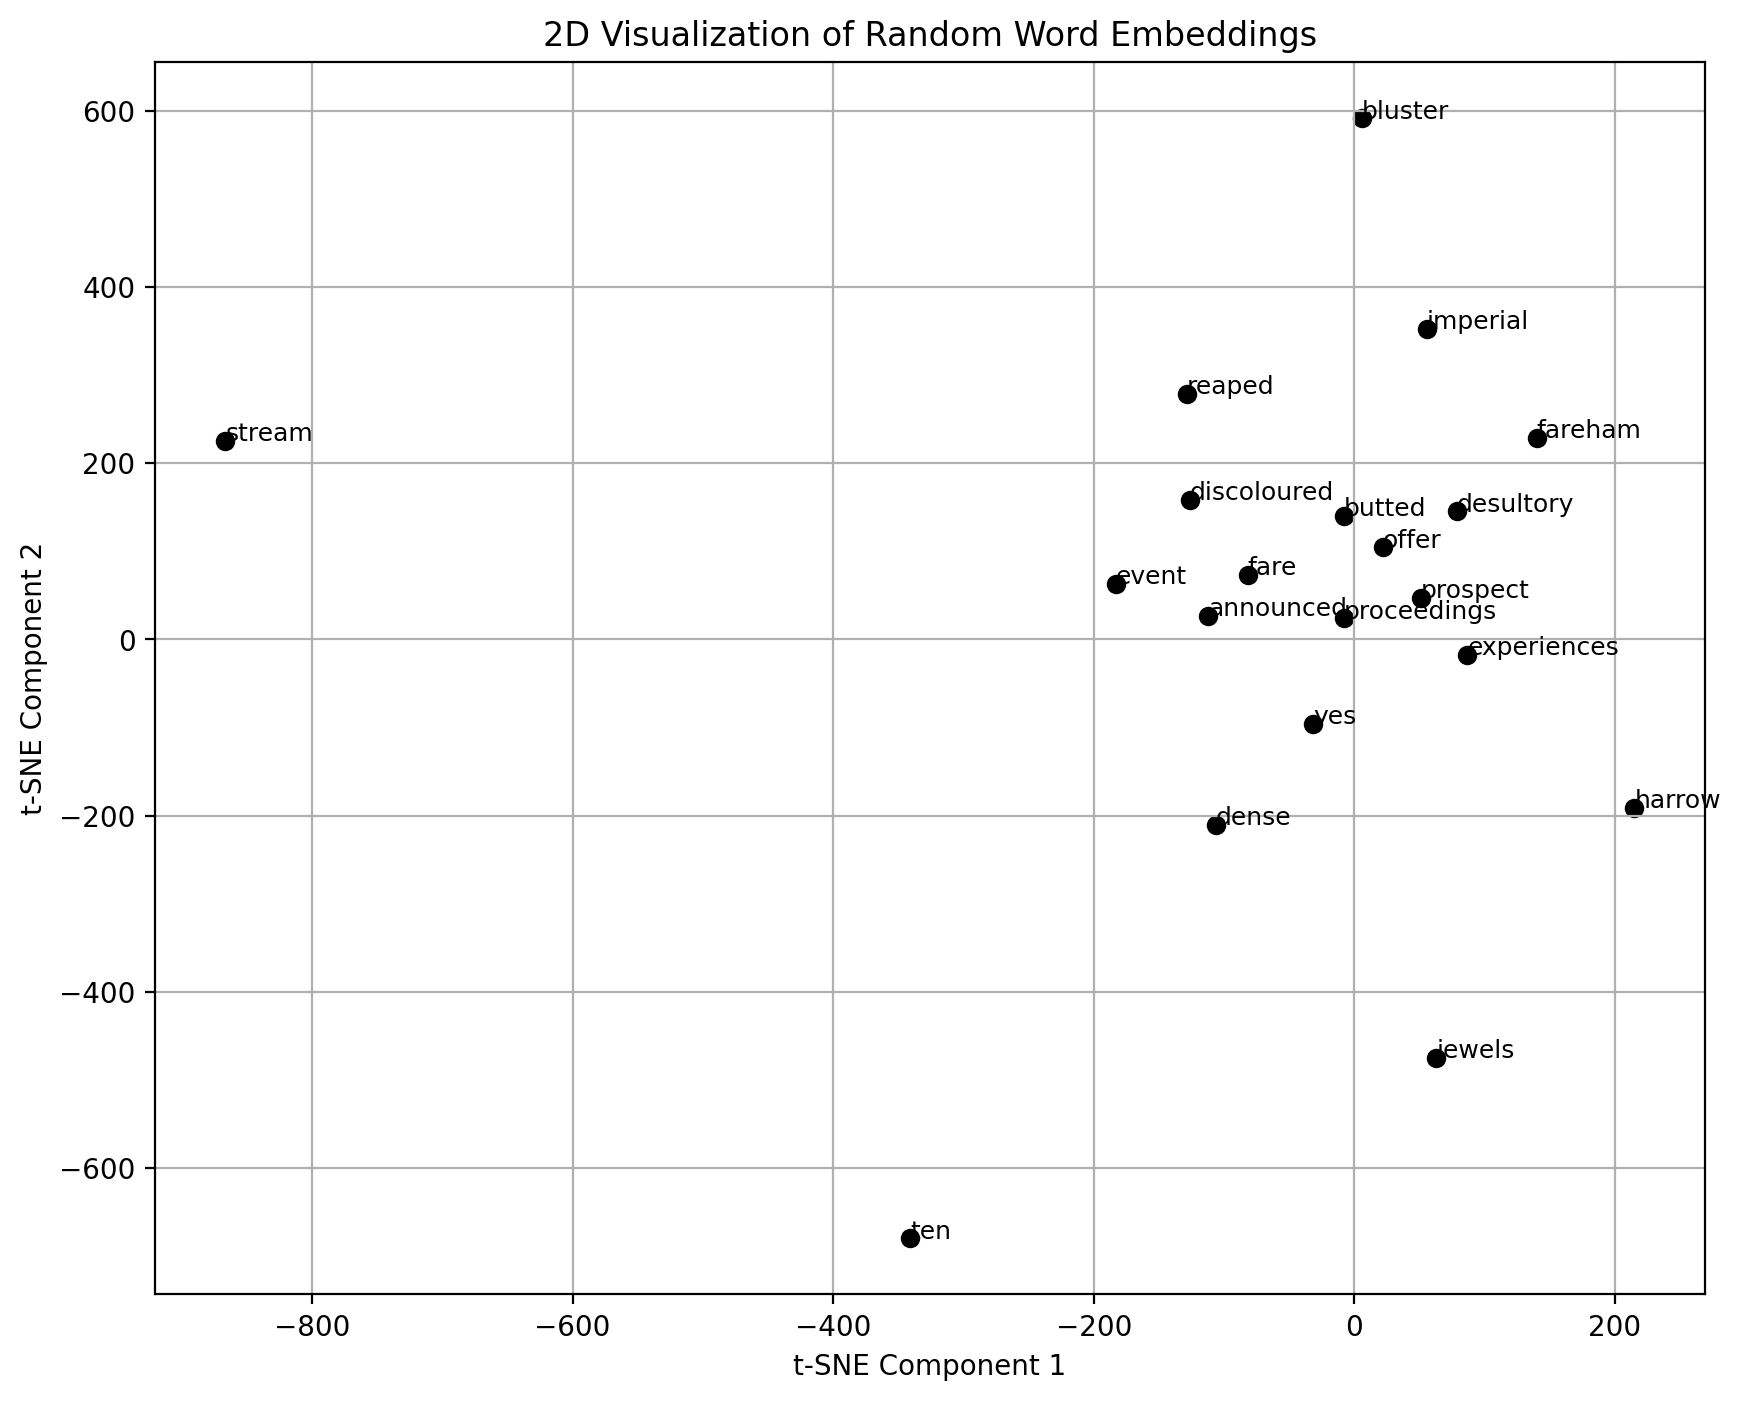

In [46]:
# Get a random sample of 20 unique indices from the vocabulary
random_indices = random.sample(range(len(itos)), 20)
random_words = {index: itos[index] for index in random_indices}

print("Random words to plot: ")
for index in random_indices:
    print(f"Index: {index}, Word: {itos[index]}")

# Plot the embeddings of these random words
def plot_embeddings(emb, itos, random_indices, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    with torch.no_grad():
        embeddings = emb.weight.detach().cpu().numpy()
    
    # Perform t-SNE
    selected_embeddings = embeddings[random_indices]
    tsne = TSNE(n_components=2, perplexity=5, learning_rate=200, n_iter=250, random_state=42)
    reduced_embeddings = tsne.fit_transform(selected_embeddings)

    for i, index in enumerate(random_indices):
        x, y = reduced_embeddings[i]
        ax.scatter(x, y, color='k')
        ax.text(x + 0.05, y + 0.05, itos[index], fontsize=9)

    ax.set_title("2D Visualization of Random Word Embeddings")
    ax.set_xlabel("t-SNE Component 1")
    ax.set_ylabel("t-SNE Component 2")
    plt.grid()

# Plot the random words
plot_embeddings(emb, itos, random_indices)
plt.show()


Specific words to plot:
Index: 7212, Word: the
Index: 355, Word: and
Index: 7326, Word: to
Index: 4921, Word: of
Index: 88, Word: a
Index: 8139, Word: you
Index: 2960, Word: for
Index: 3951, Word: is
Index: 7252, Word: those
Index: 349, Word: an
Index: 7847, Word: was
Index: 7977, Word: whose


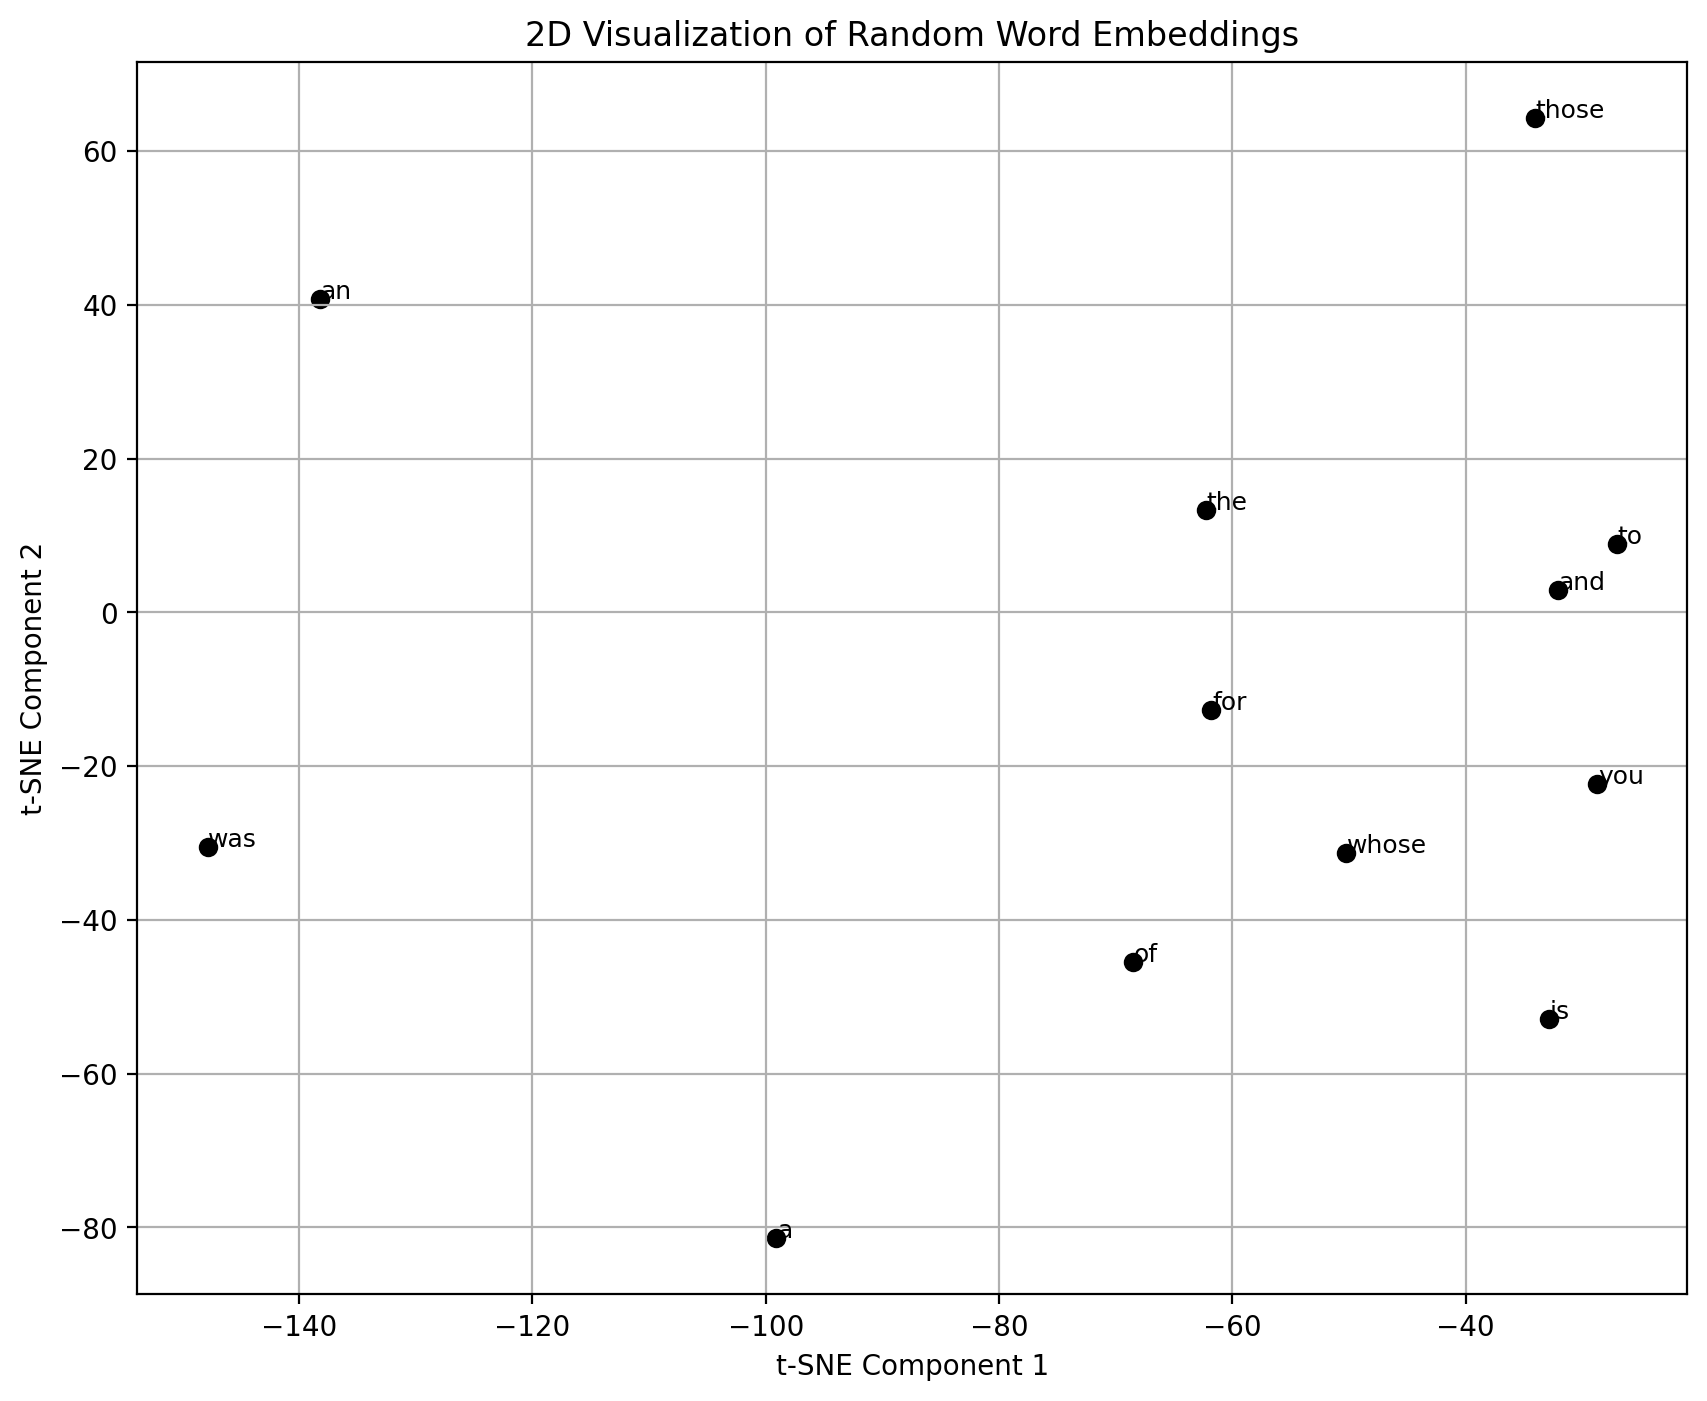

In [47]:
# List of specific words
specific_words = ['the', 'and', 'to', 'of', 'a', 'you', 'for', 'is', 'those', 'an', 'was', 'whose']  
specific_indices = [stoi[word] for word in specific_words if word in stoi]  

print("Specific words to plot:")
for index in specific_indices:
    print(f"Index: {index}, Word: {itos[index]}")

# Plot the specific words
plot_embeddings(emb, itos, specific_indices)
plt.show()

In [ ]:
# Streamlit code

import streamlit as st

# Define the WordPredictionModel class
class WordPredictionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, activation_function):
        super(WordPredictionModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lin1 = nn.Linear(embedding_dim, hidden_dim)
        self.activation = activation_function
        self.lin2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embeddings(x)
        x = x.mean(dim=1)
        x = self.activation(self.lin1(x))
        x = self.lin2(x)
        return x

# Function to load `stoi`, `itos` and model
def load_model_files(activation_choice, embedding_dim_choice, context_length_choice, device):
    # Create filenames dynamically based on the parameters
    model_filename = f'model_{activation_choice}_{embedding_dim_choice}_{context_length_choice}.pth'
    stoi_filename = f'stoi_{activation_choice}_{embedding_dim_choice}_{context_length_choice}.pkl'
    itos_filename = f'itos_{activation_choice}_{embedding_dim_choice}_{context_length_choice}.pkl'

    # Check if files exist
    if not (os.path.exists(model_filename) and os.path.exists(stoi_filename) and os.path.exists(itos_filename)):
        raise FileNotFoundError(f"Model or mapping files not found for: {model_filename}")

    # Load the `stoi` and `itos` mappings
    with open(stoi_filename, 'rb') as f:
        stoi = pickle.load(f)
    with open(itos_filename, 'rb') as f:
        itos = pickle.load(f)

    # Load the model
    vocab_size = len(stoi)  # Assuming vocab_size is the size of `stoi`
    hidden_dim = 1024  # Fixed hidden layer size
    activation_function = nn.ReLU() if activation_choice == 'ReLU' else nn.Tanh()  # Select activation function
    
    # Initialize the model and load the state dict
    model = WordPredictionModel(vocab_size, embedding_dim_choice, hidden_dim, activation_function)
    model.load_state_dict(torch.load(model_filename, map_location=device, weights_only=True))
    model.to(device)
    model.eval()

    return model, stoi, itos

# Streamlit UI
st.title("Next k Word Generator")
st.write('''This is a model which predicts the next k words based on the input given by the user. It has
 trained on the dataset of "Sherlock Holmes" by Arthur Conan Doyle.''')
st.write("Enter the starting words and the number of words to generate.")
st.write("You can also adjust other parameters such as activation function, embedding dimension and context length.")

# User input for starting words and number of words to generate
start_sequence = st.text_input("Starting words", " ")
start = re.sub(r'[^a-z0-9\s.]', '', start_sequence.lower())
k = st.number_input("Number of words to generate", min_value=1)

# Define parameter options for the models
activation_functions = ['ReLU', 'Tanh']
embedding_dimensions = [32, 64]
context_lengths = [5, 10]

# Dropdowns for selecting parameters
activation_choice = st.selectbox("Activation Function", activation_functions)
embedding_dim_choice = st.selectbox("Embedding Dimension", embedding_dimensions)
context_length_choice = st.selectbox("Context Length", context_lengths)

st.write("Selected Parameters: ")
st.write("Context Length - ", context_length_choice)
st.write("Activation Function - ", activation_choice)
st.write("Embedding Dimension - ", embedding_dim_choice)
st.write("Number of hidden layers - ", 1024)

# Load model, stoi, and itos based on the selected parameters
try:
    model, stoi, itos = load_model_files(activation_choice, embedding_dim_choice, context_length_choice, device)
except FileNotFoundError as e:
    st.error(str(e))
else:
    # Button to generate text
    if st.button("Generate Text"):
        generated_text = generate_next_k_words(model, start, k, stoi, itos, context_length_choice, device)
        st.write("GENERATED TEXT:")
        st.write(generated_text)
